# NWTC site characterization through M4 and M5

## setup

In [1]:
import os, glob
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import BoundaryNorm
import funcs as funcs
import datetime

import imp
import met_funcs as MET

In [2]:
%matplotlib inline
fs = 12
plt.rc('font', family='serif')
plt.rc('font', size=fs)
plt.rc('facecolor', )

In [7]:
# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/M5Twr)
metPathLoHz = '/Volumes/135mData/M5Twr/10min/txt/'
figPath = '../../figs/'
# metPathLoHz = '/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/'

In [15]:
# time range
years  = [ int(a) for a in np.arange(2017,2018,1) ] #
# years = [2017]
months = [ int(a) for a in np.arange(1,2.1,1) ]

# READ IN DATA

<module 'met_funcs' from '/Volumes/Sitechar/coderepo/nicholas/met_funcs.py'>

In [17]:
inputfiles = [] # list of files to be read into metdata object
filecount = 0

for year in years:
    for month in months:
        fName = glob.glob(os.path.join(metPathLoHz,'{0}_{1}.txt'.format(year,month_name[month])))        
        if len(fName)>0:
            fName = fName[0] 
            inputfiles.append(fName)
print('{} files to be read into MetData'.format(len(inputfiles)))

metdat = MET.load_met_data(inputfiles)
## remove columns that are all nans
MET.drop_nan_cols(metdat)
## use qc columns to mask data (qc != 1 => questionable data)
metdat = MET.qc_mask(metdat)

2 files to be read into MetData
number of data columns: 461
number of QC columns: 471


### column names for various QOIs

In [23]:

varcats, varunits, varlabels, varsave = MET.categorize_fields(metdat, keeplist=True)

# a few ad hoc corrections
varlabels['turbulent kinetic energy'] = 'TKE'+ varunits['turbulent kinetic energy']
varlabels['direction'] = 'Wind ' + varlabels['direction']
varlabels['speed'] = 'Wind ' + varlabels['speed']
varlabels[ 'stability parameter z/l'] =  'Stability Parameter z/L [--]'

In [7]:
# filter TI to where wind speed >= 3 m/s
for ii,_ in enumerate(varcats['speed']):
    metdat.loc[metdat[varcats['speed'][ii]]<3,varcats['ti'][ii]] = np.nan

# filter obhukov length
for col in varcats['monin-obukhov length']:
    metdat.loc[np.abs(metdat[col])>2000, col] = np.nan
    
# filter sonic temperatures (kelvins vs degrees C)
for col in varcats['air temperature']:
    metdat.loc[np.abs(metdat[col])>200, col] = metdat.loc[np.abs(metdat[col])>200, col]-273

# filter gradient richardson number
for col in varcats['gradient richardson']:
    metdat.loc[np.abs(metdat[col])>20, col] = np.nan

## stability 

In [8]:
# tmp = filt[varcats['ti']+varcats['direction']+varcats['monin-obukhov length']].copy()

for col in varcats['monin-obukhov length']:
    z = int(col.split('m')[0].split('(')[-1])
    newcolname = 'Stability Flag ({}m)'.format(z)

    L = metdat[col].copy()
    categoriesIdx = {'Very Stable': (L>0) & (L<=200),
                     'Stable' : (L>200) & (L<=500),
                     'Neutral' : (L<-500) | (L>500),
                     'Unstable' : (L>=-500) & (L<-200),
                     'Very Unstable': (L>=-200) & (L<0)}

    metdat[newcolname] = np.nan
    for cat in categoriesIdx.keys():
        metdat.loc[categoriesIdx[cat],newcolname] = cat
        
varcats['stability flag'] = [x for x in metdat.columns if 'Stability Flag' in x]   
stabconds = [x for x in categoriesIdx]

## drop unused columns

In [9]:
# columns to keep
keeplist = [x for key in varcats for x in varcats[key]]
# columns to drop
droplist = list(set(metdat.columns) - set(keeplist))
metdat = metdat.drop(columns = droplist)

### outlier detection and assignment to NaN

In [90]:
test = metdat.copy()
for col in test.columns:
    try:
        test[col] = MET.reject_outliers(test[col], m=5)
    except:
        continue

# Profiles by stability

In [43]:




for cat in varcats:
    if 'stab' in cat.lower():
        continue
#     pdat = plotdat[varcats[cat]].get_values()
    
#     # extract vertical locations of data from variable names
#     category, vertlocs, ind = MET.get_vertical_locations(varcats[cat]) 
    
#     fig, ax = plt.subplots(figsize=(3.5,5))
#     for ii, cond in enumerate(stabconds):

#         ax.plot(pdat[ii,ind], vertlocs, color=colors[ii])

#     ax.set_ylabel('Probe Height [m]')
#     ax.set_xlabel(varlabels[cat])
#     fig.legend(stabconds, loc=6, bbox_to_anchor=(1,0.5), frameon=False)

#     fig.tight_layout()
    fig.savefig(os.path.join(figPath,'profiles','stability','{}_profiles.png'.format(cat)), dpi=200, bbox_inches='tight')
    
    plt.close('all')

## monthly breakout

In [73]:
stab, stabloc, ind = MET.get_vertical_locations(varcats['stability flag'], location=100)

plotdat = test.groupby([test.index.month,stab])
colors = MET.get_colors(5,basecolor='span')
months = MET.monthnames()

for cat in varcats:
    if 'stab' in cat.lower():
        continue
    
    # extract vertical locations of data from variable names
    category, vertlocs, ind = MET.get_vertical_locations(varcats[cat]) 
    
    fig, ax = plt.subplots(4,3, figsize=(8,13), sharex=True, sharey=True)
    for iax, month in enumerate(months):
        
        for ii, cond in enumerate(stabconds):

            pdat = plotdat[varcats[cat]].get_group((iax+1, cond)).mean()
            ax.flatten()[iax].plot(pdat[ind], vertlocs, color=colors[ii])

        ax.flatten()[iax].set_title(month)
#         ax.flatten()[iax].set_xlabel(varlabels[cat])

    fig.text(0,0.58, 'Probe Height [m]', ha='center', va='center', fontsize=14, rotation='vertical')
    leg = fig.legend(stabconds, loc=8, bbox_to_anchor=(0.55, 0), frameon=False)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.175)
    fig.text(0.525,0.135, varlabels[cat], ha='center', va='center', fontsize=14)

    fig.savefig(os.path.join(figPath,'profiles','stability','monthly','{}_profiles.png'.format(cat)), dpi=200, bbox_inches='tight')
    
    plt.close('all')

# normalized histograms by stability

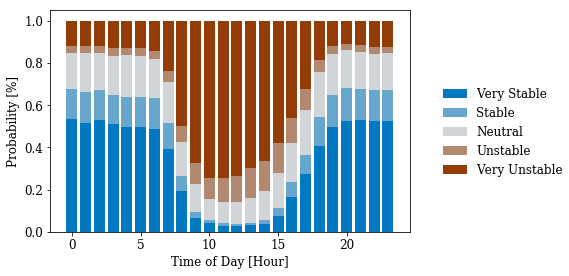

In [218]:
temp = test[varcats['stability flag'][0]].dropna()
garb = temp.groupby(temp.index.hour).value_counts(normalize=True)
garb.index.names = ['hour','stabclass']
garb = garb.reorder_levels(['stabclass','hour'])

hours = np.arange(24)
colors = MET.get_colors(5,basecolor='span')
newbottom = np.zeros(24)

fig,ax = plt.subplots()
for jj,cond in enumerate(stabconds):
    
    ax.bar(hours, garb.loc[cond], color=colors[jj], bottom=newbottom)
    newbottom += garb.loc[cond]

ax.set_ylabel('Probability [%]')
ax.set_xlabel('Time of Day [Hour]')
fig.legend(stabconds, loc=6, bbox_to_anchor=(1,0.5),framealpha=0)
fig.tight_layout()

fig.savefig(os.path.join(figPath,'histograms','normalized_stability.png'), dpi=200, bbox_inches='tight')


## monthly version

/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.


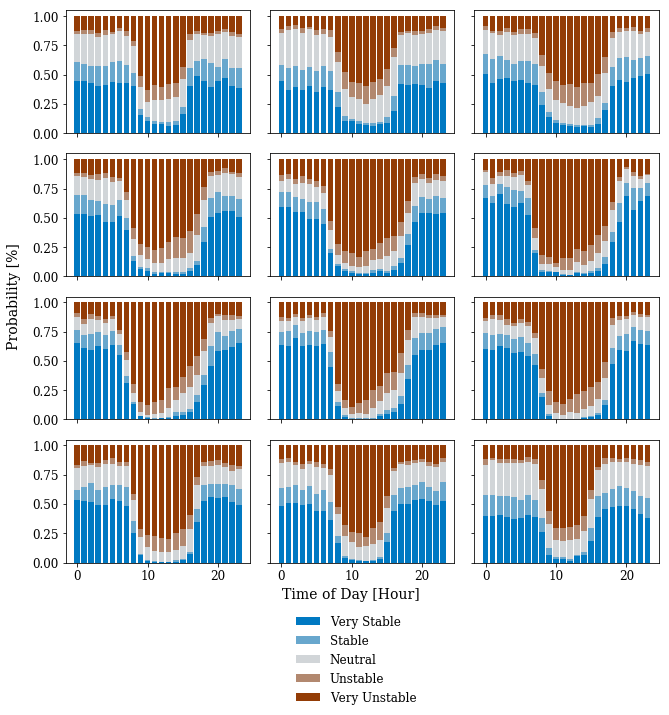

In [227]:
months = MET.monthnames()
hours = np.arange(24)
colors = MET.get_colors(5,basecolor='span')

temp = test[varcats['stability flag'][0]].dropna()
plotdata = temp.groupby([temp.index.month, temp.index.hour]).value_counts(normalize=True)
plotdata.index.names = ['month','hour','stabclass']
temp = plotdata.reorder_levels(['month','stabclass','hour'])

indexvals = [np.arange(1,13),stabconds, np.arange(24)]
indx = pd.MultiIndex.from_product(indexvals, names=['month','stabclass','hour'])
temp=temp.reindex(index=indx).fillna(0.0)

fig,ax = plt.subplots(4,3, figsize=(9,10), sharex=True, sharey=True)
for ii,month in enumerate(months):
    newbottom = np.zeros(24)

    for jj,cond in enumerate(stabconds):
        
        pdat = temp.loc[ii+1,cond]
        
        ax.flatten()[ii].bar(hours, pdat, color=colors[jj],bottom=newbottom)
        
        newbottom += pdat
        
# fig.legend(stabconds, loc=8, bbox_to_anchor=(0, -0.1), edgecolor='w')
fig.text(-0.02,0.58, 'Probability [%]', ha='center', va='center', fontsize=14, rotation='vertical')
leg = fig.legend(stabconds, loc=8, bbox_to_anchor=(0.55, 0), edgecolor='w')
fig.tight_layout()
fig.subplots_adjust(bottom=0.21)
fig.text(0.5,0.165, 'Time of Day [Hour]', ha='center', va='center', fontsize=14)

fig.savefig(os.path.join(figPath,'histograms','monthly_normalized_stability.png'), dpi=200, bbox_inches='tight')


# average daily trends

In [12]:
for cat in varcats:
    if 'stability flag' in cat.lower():
        continue
    fig, ax = MET.hourlyplot(test, varcats[cat], basecolor='span')
    ax.set_ylabel(varlabels[cat])
    fig.savefig(os.path.join(figPath,'ave_day','{}.png'.format(varsave[cat])), dpi=200, bbox_inches='tight')

    plt.close('all')


# Average daily trends by month

In [261]:
imp.reload(MET)
for cat in varcats:
    if 'stability flag' in cat.lower():
        continue
    fig, ax = MET.monthlyhourlyplot(test, varcats[cat], basecolor='span')
    fig.text(0, 0.625, varlabels[cat], ha='center', va='center', rotation='vertical')
    
    fig.savefig(os.path.join(figPath,'monthly','{}.png'.format(varsave[cat])), dpi=200, bbox_inches='tight')

    plt.close('all')

## TI rose by height

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


NameError: name 'gcf' is not defined

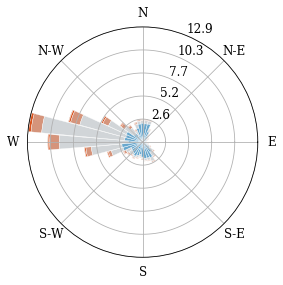

In [243]:
# get and SORT column names for wind speed and direction
dirs, dirlocs, _ = MET.get_vertical_locations(varcats['direction'])
spds, spdlocs, _ = MET.get_vertical_locations(varcats['ti'])
title = varlabels['ti']

# wind speed bins to use in wind roses
bins = np.linspace(0,50,7)

for ind,height in enumerate(spdlocs):
    
    plotdat = test[[dirs[ind],spds[ind]]]
    plotdat = plotdat.dropna(how='all',axis=1)
    if len(plotdat.columns)==1:
        print('skipping {} m'.format(height))
        continue

    fig, ax, leg = MET.rose_fig(plotdat[dirs[ind]],plotdat[spds[ind]], bins=bins ,ylim=12)
    leg.set_title(title)
    ax.set_title('z = {} [m]'.format(height), x= 1.35,y=0.15, fontsize=14)

#     fig.tight_layout()

    fig.savefig(os.path.join(figPath,'windroses','TI_rose_{}m.png'.format(height)), dpi=200, bbox_inches='tight')
    
    plt.close('all')
    

# Wind Rose by height

In [17]:
# get and SORT column names for wind speed and direction
dirs, dirlocs, _ = MET.get_vertical_locations(varcats['direction'])
spds, spdlocs, _ = MET.get_vertical_locations(varcats['speed'])
title = varlabels['speed']

# wind speed bins to use in wind roses
bins = np.linspace(0,24,7)

for ind,height in enumerate(spdlocs):
    
    plotdat = test[[dirs[ind],spds[ind]]]
    plotdat = plotdat.dropna(how='all',axis=1)
    if len(plotdat.columns)==1:
        print('skipping {} m'.format(height))
        continue

    fig, ax, leg = MET.rose_fig(plotdat[dirs[ind]],plotdat[spds[ind]], bins=bins ,ylim=9)
    leg.set_title(title)
    ax.set_title('z = {} [m]'.format(height), x= 1.3,y=0.15, fontsize=14)

    fig.tight_layout()

    fig.savefig(os.path.join(figPath,'windroses','windrose_{}m.png'.format(height)), dpi=200, bbox_inches='tight')
    
    plt.close('all')
    

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


skipping 30 m
skipping 55 m
skipping 80 m
skipping 105 m
skipping 130 m


# Wind Rose by Month

In [25]:
imp.reload(MET)
monthlydat = test.groupby(test.index.month)
months = MET.monthnames()

winddir, vertloc, ind = MET.get_vertical_locations(varcats['direction'], location=100)
var, vertloc, ind = MET.get_vertical_locations(varcats['speed'], location=100)

# wind speed bins to use in wind roses
bins = np.linspace(0,24,7)

# monthlydat[winddir,var].head()
for ii,month in enumerate(months):
    
    fig,ax,leg = MET.rose_fig(monthlydat[winddir].get_group(ii+1), monthlydat[var].get_group(ii+1), bins=bins, ylim=12)
    leg.set_title('Wind Speed [m/s]')
    ax.set_title('z = {} [m]'.format(height), x= 1.3,y=0.15, fontsize=14)
    fig.text(x=0.865,y=0.175, s=month)

    fig.tight_layout()
    
    fig.savefig(os.path.join(figPath,'windroses','monthly','windrose_{}_{}m.png'.format(month,vertloc)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


# TI rose by month

In [36]:
monthlydat = test.groupby(test.index.month)
months = MET.monthnames()
title = varlabels['ti']
winddir, vertloc, ind = MET.get_vertical_locations(varcats['direction'], location=100)
var, vertloc, ind = MET.get_vertical_locations(varcats['ti'], location=90)

for ii,month in enumerate(months):

    fig,ax,leg = MET.rose_fig(monthlydat[winddir].get_group(ii+1), monthlydat[var].get_group(ii+1), ylim=18)
    leg.set_title(title)
    ax.set_title('z = {} [m]'.format(vertloc), x= 1.35,y=0.135, fontsize=14)
    fig.text(0.935,0.175,month, ha='center', va='center',fontsize=14)
    fig.tight_layout()
    
    fig.savefig(os.path.join(figPath,'windroses','monthly','TI_rose_{}_{}m.png'.format(month,vertloc)), dpi=200, bbox_inches='tight')

    plt.close('all')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


# A year's worth of wind roses

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


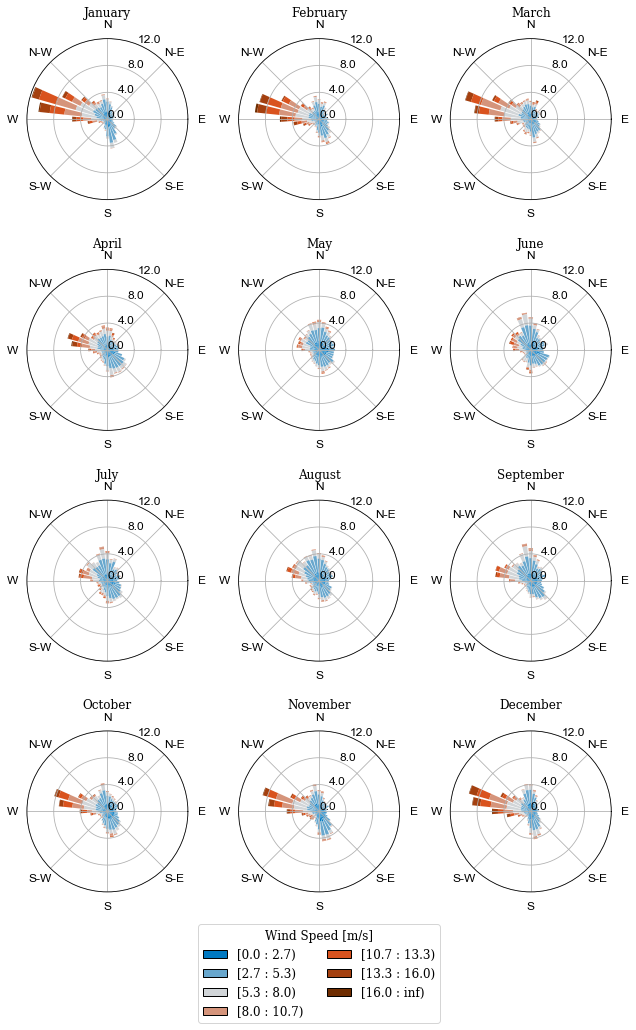

In [71]:
imp.reload(MET)
monthlydat = test.groupby(test.index.month)

winddir, vertloc, ind = MET.get_vertical_locations(varcats['direction'], location=100)
var, vertloc, ind = MET.get_vertical_locations(varcats['speed'], location=100)

winddir = monthlydat[winddir]
var = monthlydat[var]

fig, ax, leg = MET.monthly_rose_fig(winddir, var, 16, 12)
leg.set_title(varlabels['speed'])
        
fig.tight_layout()    
fig.savefig(os.path.join(figPath,'windroses','monthly','windrose_fullyear_{}m.png'.format(vertloc)), dpi=200, bbox_inches='tight')


/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


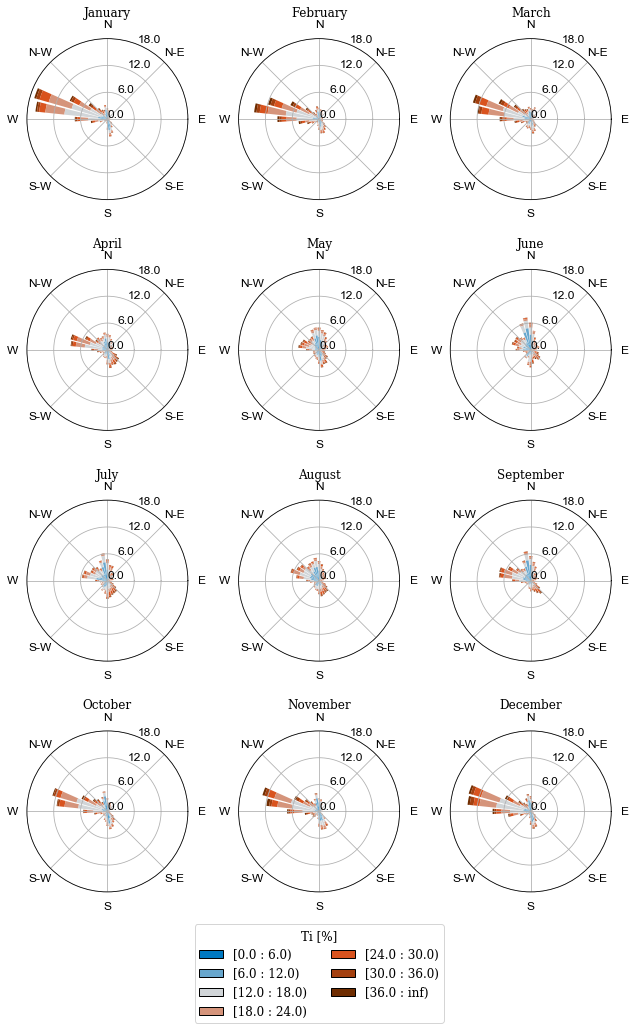

In [72]:
monthlydat = test.groupby(test.index.month)

winddir, vertloc, ind = MET.get_vertical_locations(varcats['direction'], location=100)
var, vertloc, ind = MET.get_vertical_locations(varcats['ti'], location=100)

winddir = monthlydat[winddir]
var = monthlydat[var]

fig, ax, leg = MET.monthly_rose_fig(winddir, var, 36, 18)
leg.set_title(varlabels['ti'])
        
fig.tight_layout()    
fig.savefig(os.path.join(figPath,'windroses','monthly','TI_fullyear_{}m.png'.format(vertloc)), dpi=200, bbox_inches='tight')


# histograms 

In [125]:
# histograms of cumulative data

for cat in varcats:
    if 'stability flag' in cat.lower():
        continue
    # get name of column in category closest to vertical location
    categ, vertloc, ind = MET.get_vertical_locations(varcats[cat], location=100)

    fig, ax = MET.hist(test, categ)
    fig.text(0.5,0,varlabels[cat], ha='center', va='center')
    fig.tight_layout()
    
    fig.savefig(os.path.join(figPath,'histograms','{}_hist_{}m.png'.format(varsave[cat],vertloc)), dpi=200, bbox_inches='tight')
    
    plt.close('all')

## aggregate data grouped by stability class

NameError: name 'df' is not defined

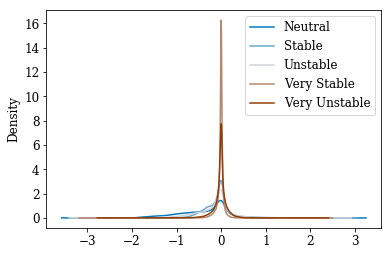

In [42]:
cat='cov(u_w)'
stab, vertloc, stind = MET.get_vertical_locations(varcats['stability flag'], location=100)
var, vertloc, varind = MET.get_vertical_locations(varcats[cat], location=100)
colors = MET.get_colors(len(stabconds), basecolor='span')

stabdat = test.groupby(stab)
# temp = stabdat[var]
# temp.plot(kind='bar', by=stab)
temp = pd.DataFrame({cond: stabdat[var].get_group((cond)) for cond in stabconds})

temp.plot.kde(color=colors)#stacked=True, bins=35, color=colors,edgecolor='k',density=False)#, weights=np.ones(35)/ temp.size)
ax = df.a.plot(kind='hist')
df.a.plot(kind='kde', ax=ax, secondary_y=True)

ValueError: weights should have the same shape as a.

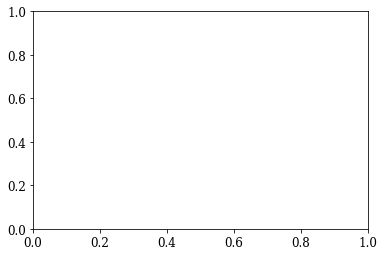

In [74]:
imp.reload(MET)
for cat in ['speed','cov(u_w)']:#varcats:
    if 'stability flag' in cat.lower():
        continue
    stab, vertloc, stind = MET.get_vertical_locations(varcats['stability flag'], location=100)
    var, vertloc, varind = MET.get_vertical_locations(varcats[cat], location=100)
    
    stabdat = test.groupby(stab)

    fig, ax = MET.stacked_hist_by_stability(stabdat[var], stabconds)
    fig.text(0.5,0,varlabels[cat], ha='center', va='center')
    fig.tight_layout()
    
#     fig.savefig(os.path.join(figPath,'histograms','stability','{}_hist_{}m.png'.format(varsave[cat],vertloc)), dpi=200, bbox_inches='tight')
    
#     plt.close('all')

## stacked histograms (sliced by stability)

# start slicing (groupby month and stability)

In [ ]:
temp = pd.DataFrame({cond: monthly_stability.get_group((1,cond)) for cond in stabconds})


In [ ]:
imp.reload(MET)
for cat in ['cov(u_w)']:#varcats
    if 'stability flag' in cat.lower():
        continue
    stab, vertloc, stind = MET.get_vertical_locations(varcats['stability flag'], location=100)
    var, vertloc, varind = MET.get_vertical_locations(varcats[cat], location=100)
    
    monthly_stability = test.groupby([test.index.month, test[stab]])
    
    fig, ax, leg = MET.monthly_stacked_hist_by_stability(monthly_stability[var], stabconds)
    
    fig.text(0.5,0.16, varlabels[cat], ha='center', va='center', fontsize=14)

#     fig.savefig(os.path.join(figPath,'monthly','{}_{}m_stacked_hist.png'.format(varsave[cat],vertloc)),
#                 dpi=200, bbox_inches='tight')
#     plt.close('all')

## scatter plots by height and stability

In [124]:
# test = tmp.copy()
colors = MET.get_colors(5,basecolor='span')
nrelcolors = MET.getnrelcolors()

for cat in varcats:

    dirind, catind, heights = MET.get_nearest_direction(filt, varcats['direction'], varcats[cat])
    _, stabind, _ = MET.get_nearest_stability(filt, varcats['stability flag'], varcats[cat])

    temp = np.zeros(0)
    minmax = []
    for col, _ in enumerate(varcats[cat]):
        temp = np.concatenate((temp, np.asarray(filt[varcats[cat][col]].dropna(how='any'))))
    temp = MET.reject_outliers(temp, m=5)
    minmax = [temp.min(), temp.max()]
#     minmax = [MET.Round_To_n(temp.min(),0), MET.Round_To_n(temp.max(),0)]
    print('plot limits for {} are:'.format(cat), minmax)
    
    for height in range(len(heights)):
        
        if len(filt[varcats['direction'][dirind[height]]].dropna(how='all')) == 0:
            print('empty')
            continue
        
        fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize=(6,8))

        for ind, stabcond in enumerate(categoriesIdx.keys()):
            idx  = filt[varcats['stability flag'][1]]==stabcond

            ax.flatten()[ind].scatter(filt.loc[idx,varcats['direction'][dirind[height]]],filt.loc[idx,varcats[cat][catind[height]]],marker='o',facecolor=colors[ind],color='k',lw=0.5,alpha=0.7)#,label=labels[categ])
            ax.flatten()[ind].set_xlim([0,360])
            ax.flatten()[ind].set_ylim(minmax)
            ax.flatten()[ind].legend([stabcond], fontsize=12, loc=1)

            ax.flatten()[ind].axvspan(0, 46, alpha=0.1, color=nrelcolors['red'][0])
            ax.flatten()[ind].axvspan(228, 3600, alpha=0.1, color=nrelcolors['red'][0])


        fig.text(0.5,0, r'Wind Direction [$^\circ$]', ha='center', va='center')
        fig.text(0, 0.5, varlabels[cat], ha='center', va='center', rotation='vertical')

        fig.tight_layout()

        fig.savefig(os.path.join(figPath,'scatter','stability','{}_scatter_{}m.png'.format(varsave[cat],heights[height])), dpi=200, bbox_inches='tight')
    
    plt.close('all')
    
    

AttributeError: module 'met_funcs' has no attribute 'getnrelcolors'

In [ ]:
# test = tmp.copy()

# fig, ax = MET.stability_winddir_scatter(test, 'TI', varcats)
# plt.subplots(5,1, sharex=True, sharey=True, figsize=(6,8))

# for ind, categ in enumerate(categoriesIdx.keys()):
#     idx  = test[varcats['stabflag'][1]]==categ
    
#     ax.flatten()[ind].scatter(test.loc[idx,varcats['winddir'][1]],test.loc[idx,varcats['TI'][0]],marker='o',facecolor=colors[ind],color='k',lw=0.5,alpha=0.7)#,label=labels[categ])
#     ax.flatten()[ind].set_xlim([0,360])
#     ax.flatten()[ind].set_ylim([0,120])
#     ax.flatten()[ind].legend([categ], fontsize=12, loc=1)
    
#     ax.flatten()[ind].axvspan(0, 46, alpha=0.1, color=nrelcolors['red'][0])
#     ax.flatten()[ind].axvspan(228, 3600, alpha=0.1, color=nrelcolors['red'][0])
    
    
# fig.text(0.5,0, r'Wind Direction [$^\circ$]', ha='center', va='center')
# fig.text(0, 0.5, catlabels['TI'], ha='center', va='center', rotation='vertical')
# # fig.legend(['Very Stable','Stable','Neutral','Unstable','Very Unstable'],loc=6, bbox_to_anchor=(1, 0.5), edgecolor='w')

# fig.tight_layout()



# Correltaion of variables

In [113]:
test = metdat.copy()
for col in test.columns:
    try:
        test[col] = MET.reject_outliers(test[col], m=7)
    except:
        continue

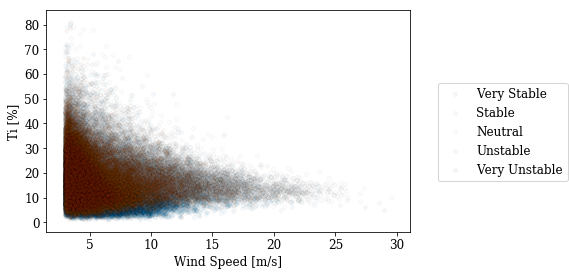

In [116]:
spdcol, vertloc, spdind = MET.get_vertical_locations(varcats['speed'], location=100)
ticol, vertloc, tiind = MET.get_vertical_locations(varcats['ti'], location=100)
stbcol, stabind, stbind = MET.get_vertical_locations(varcats['stability flag'], location=100)

fig, ax = plt.subplots()
plotdat = test.groupby(stbcol)
for ii,cond in enumerate(stabconds):

    ax.scatter(plotdat[spdcol].get_group(cond), plotdat[ticol].get_group(cond), 
               facecolor=colors[ii], s=15, alpha=0.05, edgecolor='k', linewidth=0.5)

ax.set_xlabel(varlabels['speed'])
ax.set_ylabel(varlabels['ti'])
fig.tight_layout()
fig.legend(stabconds, loc=6, bbox_to_anchor=(1,0.5))

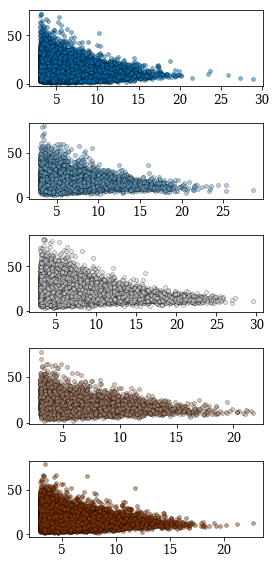

In [117]:
spdcol, vertloc, spdind = MET.get_vertical_locations(varcats['speed'], location=100)
ticol, vertloc, tiind = MET.get_vertical_locations(varcats['ti'], location=100)
stbcol, stabind, stbind = MET.get_vertical_locations(varcats['stability flag'], location=100)

fig, ax = plt.subplots(5,1, figsize=(4,8))
plotdat = test.groupby(stbcol)

for ii,cond in enumerate(stabconds):

    ax.flatten()[ii].scatter(plotdat[spdcol].get_group(cond), plotdat[ticol].get_group(cond), 
               facecolor=colors[ii], s=15, alpha=0.5, edgecolor='k', linewidth=0.5)

fig.tight_layout()
# ax.set_xlabel(varlabels['speed'])
# ax.set_ylabel(varlabels['ti'])

In [119]:
varcats.keys()

dict_keys(['air density', 'air pressure', 'air temperature', 'coherent tke', 'cov(u_w)', 'cov(w_t)', 'direction', 'dissipation rate', 'gradient richardson', 'integral length scale (u)', 'integral length scale (v)', 'integral length scale (w)', "mean(w't')", 'momentum flux', 'monin-obukhov length', 'relative humidity', 'speed', 'speed gradient richardson', 'stability parameter z/l', 'ti', 'turbulent kinetic energy', 'wind shear', 'wind veer', 'stability flag'])

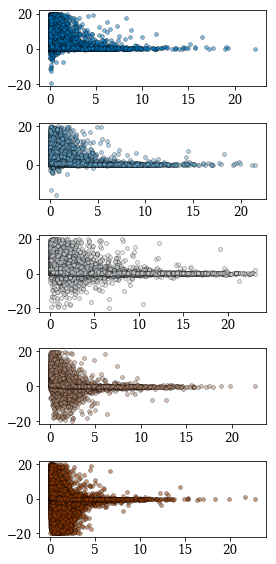

In [130]:
cat1 = 'turbulent kinetic energy'
cat2 = 'gradient richardson'
spdcol, vertloc, spdind = MET.get_vertical_locations(varcats[cat1], location=100)
ticol, vertloc, tiind = MET.get_vertical_locations(varcats[cat2], location=100)
stbcol, stabind, stbind = MET.get_vertical_locations(varcats['stability flag'], location=100)

fig, ax = plt.subplots(5,1, figsize=(4,8))
plotdat = test.groupby(stbcol)

for ii,cond in enumerate(stabconds):

    ax.flatten()[ii].scatter(plotdat[spdcol].get_group(cond), plotdat[ticol].get_group(cond), 
               facecolor=colors[ii], s=15, alpha=0.5, edgecolor='k', linewidth=0.5)

fig.tight_layout()
# ax.set_xlabel(varlabels[cat1])
# ax.set_ylabel(varlabels[cat2])

In [132]:
test = np.array([7921, 5184, 8836, 4761])

In [134]:
test.mean()

6675.5

In [ ]:
7921	96
72	5184	74
94	8836	87
69	4761